# Wind Power Forecasting RNN LSTM 
* Test Learning Rates

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_color_codes()

# Import Data

In [2]:
df = pd.read_csv('../../data/wf1.csv', index_col=0, parse_dates=True)

new_index = []
for stamp in df.index:
    new = '2' + stamp[1:]
    new_index.append(new)
    
df.index = pd.to_datetime(new_index)

df = df[['PowerGeneration',    
 'ForecastingTime',
 'AirPressure',
 'Temperature',
 'Humidity',
 'WindSpeed100m',
 'WindSpeed10m',
 'WindDirectionZonal',
 'WindDirectionMeridional']]

df.head(2)

,PowerGeneration,ForecastingTime,AirPressure,Temperature,Humidity,WindSpeed100m,WindSpeed10m,WindDirectionZonal,WindDirectionMeridional
2000-01-01 01:00:00,0.506970,25,0.392238,0.406113,0.638134,0.625094,0.548931,0.820776,0.883540
2000-01-01 02:00:00,0.579394,26,0.379920,0.405190,0.614377,0.628325,0.563099,0.812227,0.890531


In [3]:
#df.columns

In [4]:
dataset = df.copy(deep=True)
#original = df.copy(deep=True)
#dataset.info()

In [5]:
#dataset.head(2)

# Data Processing & Transformation

* Standardize Time Series: First order difference to transform from non-stationarity to stationarity.
    
* Normalize (scaling)

* Add Horizon (prediction) columns

In [6]:
from sklearn import preprocessing

pd.options.mode.chained_assignment = None
np.random.seed(42)

def drop_duplicates(df):
    print("Number of duplicates: {}".format(len(df.index.get_duplicates())))
    return df[~df.index.duplicated(keep='first')]
    
def impute_missing(df):
    # todo test with moving average / mean or something smarter than forward fill
    print("Number of rows with nan: {}".format(np.count_nonzero(df.isnull())))
    df.fillna(method='ffill', inplace=True)
    return df

# Standardize / Stationary Signal
def first_order_difference(data, columns):
    for column in columns:
        data[column+'_d'] = data[column].diff(periods=1)
    
    return data.dropna()

# Add Horizon (Prediction) columns - first order differences for target variable
def derive_prediction_columns(data, column, horizons):
    # get prediction - (i.e. change between now and lookahead) and shift back lookahead
    for look_ahead in horizons:
        data['prediction_' + str(look_ahead)] = data[column].diff(periods=look_ahead).shift(-look_ahead)
    
    return data.dropna()

def scale_features(scaler, features):
    scaler.fit(features)
    
    scaled = scaler.transform(features)
    scaled = pd.DataFrame(scaled, columns=features.columns)
    
    return scaled

def inverse_prediction_scale(scaler, predictions, original_columns, column):
    loc = original_columns.get_loc(column)
    
    inverted = np.zeros((len(predictions), len(original_columns)))
    inverted[:,loc] = np.reshape(predictions, (predictions.shape[0],))
    
    inverted = scaler.inverse_transform(inverted)[:,loc]
    
    return inverted

def invert_all_prediction_scaled(scaler, predictions, original_columns, horizons):
    inverted = np.zeros(predictions.shape)
    
    for col_idx, horizon in enumerate(horizons):
        inverted[:,col_idx] = inverse_prediction_scale(
            scaler, predictions[:,col_idx], 
            original_columns,
            "prediction_" + str(horizon))
        
    return inverted

# if not first differencing features, don't inverse first-diff the results. just return predictions
# 
#def inverse_prediction_difference(predictions, original):
#    return predictions + original*0

# original function for differenced data. 
#
def inverse_prediction_difference(predictions, original):
    return predictions + original


def invert_all_prediction_differences(predictions, original):
    inverted = predictions
    
    for col_idx, horizon in enumerate(horizons):
        inverted[:, col_idx] = inverse_prediction_difference(predictions[:,col_idx], original)
        
    return inverted


## Data Transformations

In [7]:

# select forecast features
features = dataset[['PowerGeneration',
 'ForecastingTime',
 'AirPressure',
 'Temperature',
 'Humidity',
 'WindSpeed100m',
 'WindSpeed10m',
 'WindDirectionZonal',
 'WindDirectionMeridional']]

# the time horizons we're going to predict (in hours)
horizons = [1, 6, 12, 24]

# make first order diffs and prediction columns
features = first_order_difference(features, features.columns)
features = derive_prediction_columns(features, 'PowerGeneration', horizons)

# standardize data
scaler = preprocessing.StandardScaler()
scaled = scale_features(scaler, features)

scaled.describe()

,PowerGeneration,ForecastingTime,AirPressure,Temperature,Humidity,WindSpeed100m,WindSpeed10m,WindDirectionZonal,WindDirectionMeridional,PowerGeneration_d,...,Temperature_d,Humidity_d,WindSpeed100m_d,WindSpeed10m_d,WindDirectionZonal_d,WindDirectionMeridional_d,prediction_1,prediction_6,prediction_12,prediction_24
count,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,...,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04,1.689500e+04
mean,-2.054619e-16,-7.171929e-17,5.880272e-16,-9.218235e-17,2.996715e-16,1.177645e-16,-4.201696e-17,7.689584e-17,3.610410e-16,2.386700e-17,...,9.797825e-18,1.654985e-17,-1.414146e-17,1.598471e-17,-5.362190e-18,6.305173e-18,5.000768e-18,1.209121e-18,-1.805303e-17,-2.240817e-18
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,...,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-9.228504e-01,-1.658901e+00,-3.553435e+00,-2.913015e+00,-3.792188e+00,-2.240125e+00,-2.062519e+00,-1.565024e+00,-1.601312e+00,-7.399798e+00,...,-6.067491e+00,-1.221963e+01,-1.008776e+01,-9.298278e+00,-1.456175e+01,-1.105865e+01,-7.399992e+00,-5.361236e+00,-4.167119e+00,-3.700720e+00
25%,-7.897040e-01,-9.378047e-01,-6.114158e-01,-7.960409e-01,-6.126042e-01,-7.045606e-01,-7.391140e-01,-1.091507e+00,-8.771736e-01,-3.883887e-01,...,-5.950412e-01,-4.520769e-01,-5.270774e-01,-5.203982e-01,-2.246922e-01,-2.864107e-01,-3.883597e-01,-4.698865e-01,-4.873374e-01,-4.737577e-01
50%,-3.516093e-01,7.172974e-02,5.742364e-02,5.884421e-02,2.703369e-01,-1.135953e-01,-2.265994e-01,3.122499e-01,6.698899e-03,3.534561e-04,...,-7.076646e-02,2.269673e-02,-2.315769e-02,5.066715e-03,-1.291788e-03,-3.971457e-03,3.947745e-04,6.984179e-04,1.208572e-03,3.114227e-03
75%,4.494167e-01,9.370450e-01,6.871961e-01,7.454239e-01,8.256045e-01,5.871470e-01,5.773916e-01,9.513316e-01,9.418694e-01,3.984629e-01,...,5.799493e-01,4.622093e-01,5.089117e-01,5.249501e-01,2.071139e-01,2.809220e-01,3.985169e-01,4.605439e-01,4.942366e-01,4.825708e-01
max,3.217574e+00,1.658141e+00,2.503544e+00,2.960401e+00,1.263877e+00,4.140532e+00,4.471432e+00,1.149036e+00,1.445582e+00,9.203706e+00,...,1.221017e+01,7.866214e+00,1.235599e+01,9.901633e+00,1.518351e+01,1.453270e+01,9.204041e+00,5.171275e+00,3.973819e+00,3.612608e+00


In [8]:
#features.describe()

# Create Test & Train Data for Random Forest Regresssion?

## Create Test & Train Data for Keras LSTM

In [9]:
def prepare_test_train(data, features, predictions, sequence_length, split_percent=0.7):
    
    num_features = len(features)
    num_predictions = len(predictions)
    
    # make sure prediction cols are at end
    columns = features + predictions
    
    data = data[columns].values
    
    print("Using {} features to predict {} horizons".format(num_features, num_predictions))
    
    result = []
    for index in range(len(data) - sequence_length+1):
        result.append(data[index:index + sequence_length])

    result = np.array(result)
    # shape (n_samples, sequence_length, num_features + num_predictions)
    print("Shape of data: {}".format(np.shape(result)))
    
    row = round(split_percent * result.shape[0])
    train = result[:row, :]
    
    X_train = train[:, :, :-num_predictions]
    y_train = train[:, -1, -num_predictions:]
    X_test = result[row:, :, :-num_predictions]
    y_test = result[row:, -1, -num_predictions:]
    
    print("Shape of X train: {}".format(np.shape(X_train)))
    print("Shape of y train: {}".format(np.shape(y_train)))
    print("Shape of X test: {}".format(np.shape(X_test)))
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))
    
    y_train = np.reshape(y_train, (y_train.shape[0], num_predictions))
    y_test = np.reshape(y_test, (y_test.shape[0], num_predictions))
    
    return X_train, y_train, X_test, y_test, row

In [10]:
sequence_length = 24 # sliding window size in hours

prediction_cols = ['prediction_' + str(h) for h in horizons]

"""
feature_cols = ['PowerGeneration', 'ForecastingTime', 'AirPressure', 'Temperature',
       'Humidity', 'WindSpeed100m', 'WindSpeed10m', 'WindDirectionZonal',
       'WindDirectionMeridional']

"""
feature_cols = ['PowerGeneration_d', 'AirPressure_d',
                'Temperature_d', 'Humidity_d', 'WindSpeed100m_d', 
                'WindSpeed10m_d','WindDirectionZonal_d', 
                'WindDirectionMeridional_d']


X_train, y_train, X_test, y_test, row_split = prepare_test_train(
    scaled,
    feature_cols,
    prediction_cols,
    sequence_length,
    split_percent = 0.7)


Using 8 features to predict 4 horizons
Shape of data: (16872, 24, 12)
Shape of X train: (11810, 24, 8)
Shape of y train: (11810, 4)
Shape of X test: (5062, 24, 8)


## Validate Test & Train Dataset

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#(-1 is because we only take the last y row in each sequence)
sequence_offset = sequence_length  - 1

# validate train
inverse_scale = invert_all_prediction_scaled(scaler, y_train, scaled.columns, horizons)

assert(mean_squared_error(
    features[prediction_cols][sequence_offset:row_split+sequence_offset], 
    inverse_scale) < 1e-10)


undiff_prediction = invert_all_prediction_differences(
    inverse_scale, 
    features['PowerGeneration'][sequence_offset:row_split+sequence_offset])

for i, horizon in enumerate(horizons):
    assert(mean_squared_error(
        features['PowerGeneration'][sequence_offset+horizon:row_split+sequence_offset+horizon], 
        undiff_prediction[:,i]) < 1e-10)

    
# validate test
inverse_scale = invert_all_prediction_scaled(scaler, y_test, scaled.columns, horizons)

assert(mean_squared_error(
    features[prediction_cols][sequence_offset+row_split:], 
    inverse_scale) < 1e-10)

undiff_prediction = invert_all_prediction_differences(
    inverse_scale, 
    features['PowerGeneration'][sequence_offset+row_split:])

for i, horizon in enumerate(horizons):
    assert(mean_squared_error(
        features['PowerGeneration'][sequence_offset+row_split+horizon:], 
        undiff_prediction[:-horizon,i]) < 1e-10)

## Build Non Stateful LSTM Model
A non stateful LSTM in Keras terminology resembles more of a classic sliding window approach to training, except where the successive timesteps in the window are framed one after another as a two dimensional array instead of flattened out into a long one dimensional array. This allows the LSTM to learn the state and temporal dependencies between the frames in the time window and Keras will automatically reset the state between each training window. This means that there is no ordering or continuity requirements on the training data outside of the windows.

### Build the non stateful LSTM network.

We apply regularisation via dropout between each layer in the network. This should help overfitting but we could also add L2 weight regularization. The RMSProp optimizer is recommended when working with LSTMs. The only tunable property of this is the learning rate. 

The first and last layers deserve a comment. The input_shape argument in the first layer specifies the number of input features which is X_train.shape[2]. The last layer is the output layer (hence linear activation) and the size is equal to the number of time horizons we're predicting - y_train.shape[1].

We're using a very simple network structure in this notebook with a small number of parameters in each layer. This means we should expect to see trends as opposed to capturing the finer details of the signal. With better and more abundant training data, we could look to use a bigger network with more regularization if necessary to capture higher level and more complex latent features of the signal.

import keras

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop, adam

def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(
            layers[1],
            input_shape=(None, layers[0]),
            return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[3], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[4], activation="linear"))
    
    model.compile(loss="mse", optimizer='adam')
    
    print(model.summary())
          
    return model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Train & Evaluate Model

In [13]:
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

def run_network(X_train, y_train, X_test, layers, epochs, batch_size=256):
    model = build_model(layers)
    history = None
    
    try:
        history = model.fit(
            X_train, y_train, 
            batch_size=batch_size,
            shuffle=False,
            epochs=epochs, 
            validation_split=0.1,
            callbacks=[
                TensorBoard(log_dir='/tmp/tensorboard', write_graph=True),
                #EarlyStopping(monitor='val_loss', patience=5, mode='auto')
            ])
    except KeyboardInterrupt:
        print("\nTraining interrupted")
    
    predicted = model.predict(X_test)
    
    return model, predicted, history


In [14]:
model, predicted, history = run_network(
    X_train, 
    y_train, 
    X_test,
    layers=[X_train.shape[2], 20, 15, 20, y_train.shape[1]],
    epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 15)          2160      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 15)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                2880      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total para

## Visualize Model

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='lstm_model_architecture.png', show_shapes=True, show_layer_names=True)

In [21]:
from keras.utils import vis_utils
vis_utils.plot_model(model, to_file='simple_image_lstm_architecture.png', show_shapes=True)

## Visualize Training
Plot training loss vs. valiation loss to get a better idea of whether the network is overfitting or underfitting.

In [16]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


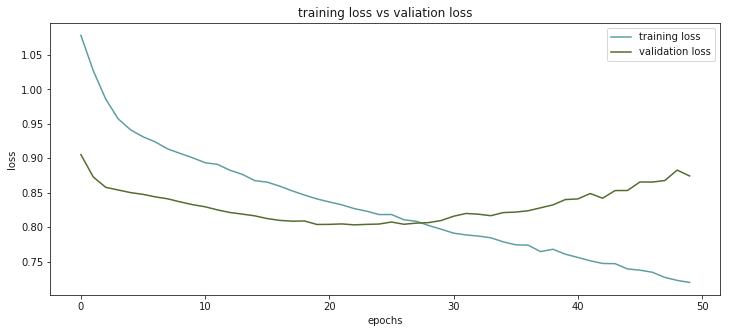

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='training loss', color='cadetblue')
plt.plot(history.history['val_loss'], label='validation loss', color='darkolivegreen')
plt.title('training loss vs valiation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

fig.savefig('lstm_train_test_loss_adam_opt.png', dpi=200, bbox_inches='tight')

## Validation
* Get error scores for the predicted test data: MSE and MAE

* Get error scores for each individual horizons

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("MAE {:.3}, MSE {:.3}".format(
    mean_absolute_error(y_test, predicted),
    mean_squared_error(y_test, predicted)))

for i, horizon in enumerate(horizons):
    print("MAE {:.3f}, MSE {:.3f} for horizon {}".format(
        mean_absolute_error(y_test[:,i], predicted[:,i]),
        mean_squared_error(y_test[:,i], predicted[:,i]),
        horizon))
    

MAE 0.641, MSE 0.792
MAE 0.596, MSE 0.814 for horizon 1
MAE 0.643, MSE 0.779 for horizon 6
MAE 0.668, MSE 0.816 for horizon 12
MAE 0.657, MSE 0.760 for horizon 24


## Unscaled Error Scores
Unscale and undifference the predictions at the various horizons. provide the error scores at scale of raw data - normalized wind power.

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

inverse_scale = invert_all_prediction_scaled(scaler, predicted, scaled.columns, horizons)

predicted_signal = invert_all_prediction_differences(
    inverse_scale, 
    features['PowerGeneration'][sequence_offset+row_split:])

for i, horizon in enumerate(horizons):
    a = features['PowerGeneration'][sequence_offset+row_split+horizon:]
    p = predicted_signal[:-horizon,i]
    
    print("Real scale predictions at horizon {:>2} has MAE {:.3f}, MSE {:.3f}, RMSE {:.3f}".format(
        horizon,
        mean_absolute_error(a, p),
        mean_squared_error(a, p),
        sqrt(mean_squared_error(a, p))))
    

Real scale predictions at horizon  1 has MAE 0.039, MSE 0.003, RMSE 0.058
Real scale predictions at horizon  6 has MAE 0.100, MSE 0.019, RMSE 0.137
Real scale predictions at horizon 12 has MAE 0.135, MSE 0.034, RMSE 0.183
Real scale predictions at horizon 24 has MAE 0.154, MSE 0.042, RMSE 0.205


## Compare to Persistence Forecast

In [20]:
def evaluate_persistence_forecast(test, horizons):
    for i, horizon in enumerate(horizons):
        a = test[horizon:]
        p = test[:-horizon]
  
        print("Persistence Method prediction at horizon {:>2} has MAE {:.3f}, MSE {:.3f}, RMSE {:.3f}".format(
            horizon,
            mean_absolute_error(a, p),
            mean_squared_error(a, p),
            sqrt(mean_squared_error(a, p))))


evaluate_persistence_forecast(
    features['PowerGeneration'][sequence_offset+row_split:].values, # ensure we have same test set 
    horizons)


Persistence Method prediction at horizon  1 has MAE 0.037, MSE 0.004, RMSE 0.059
Persistence Method prediction at horizon  6 has MAE 0.093, MSE 0.019, RMSE 0.137
Persistence Method prediction at horizon 12 has MAE 0.123, MSE 0.032, RMSE 0.179
Persistence Method prediction at horizon 24 has MAE 0.147, MSE 0.047, RMSE 0.216


## Convert negative predicted values to zero in predicted_signal

In [22]:
pred_signal_df = pd.DataFrame(predicted_signal)
pred_signal_df.describe()

# x[x < 0] = 0
predicted_signal[predicted_signal < 0] = 0


## Visualizing Predictions

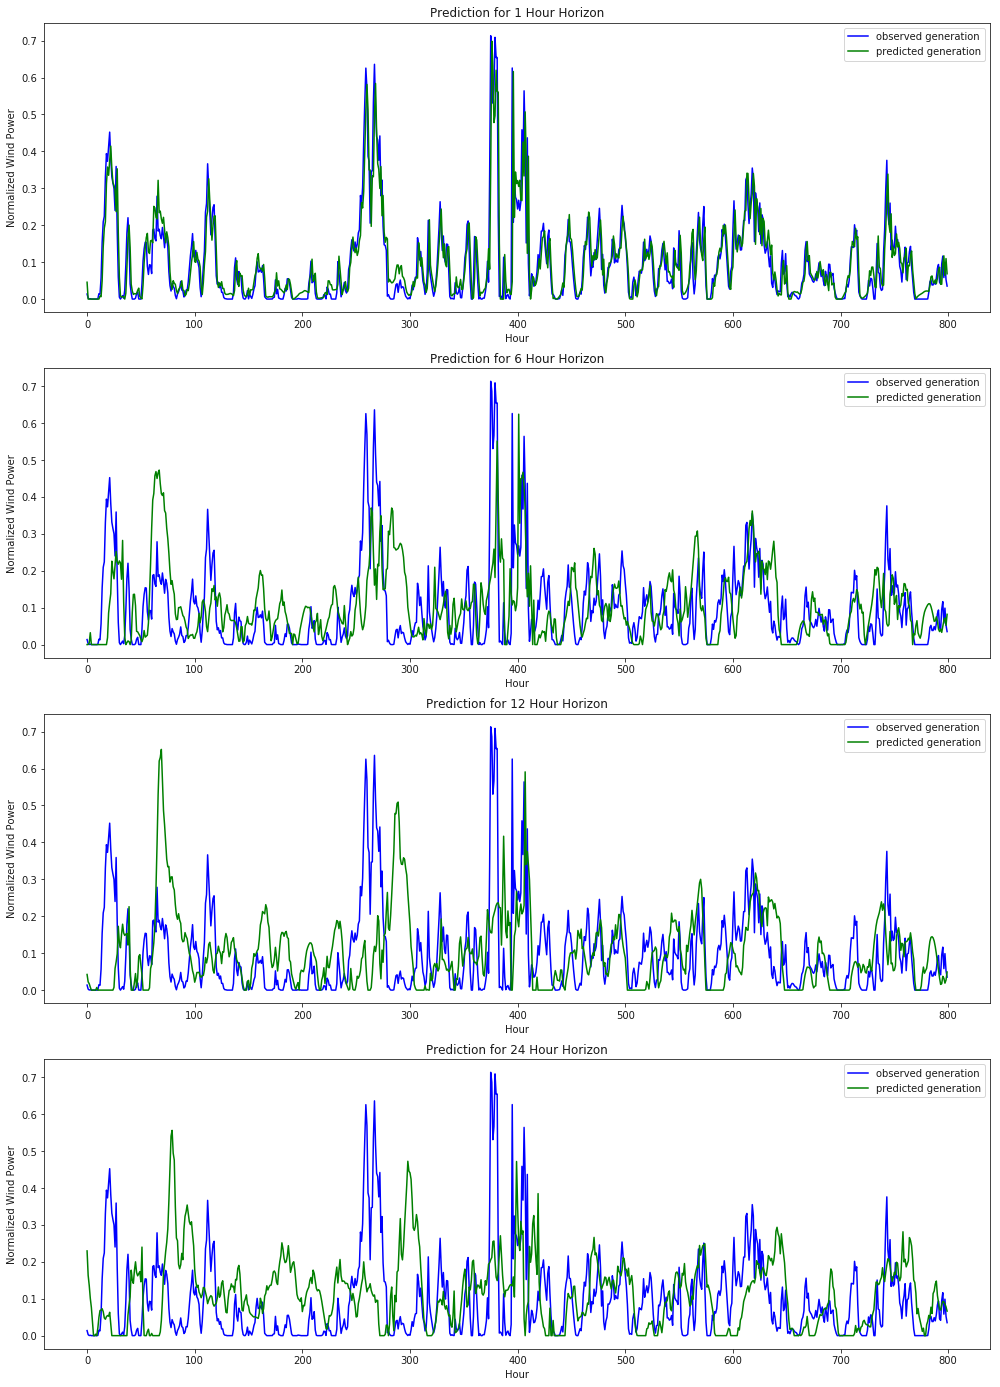

In [23]:
import matplotlib.pyplot as plt

plot_samples=800
max_horizon = horizons[-1]
plots = len(horizons)

fig = plt.figure(figsize=(14, 5 * plots))
#fig.subtitle("Model Prediction for Different Hourly Horizons")

for i, horizon in enumerate(horizons):
    plt.subplot(plots,1,i+1)
    
    len_adjust = max_horizon-horizon # ensure all have same length
    
    real = features['PowerGeneration'][sequence_offset+row_split+horizon+len_adjust:].values
    pred = predicted_signal[len_adjust:-horizon,i]
    
    plt.plot(real[:plot_samples], label='observed generation', color='blue')
    plt.plot(pred[:plot_samples], label='predicted generation', color='green')
    plt.title("Prediction for {} Hour Horizon".format(horizon))
    plt.xlabel("Hour")
    plt.ylabel("Normalized Wind Power")
    plt.legend()
    plt.tight_layout()
    
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.savefig('lstm_obs_vs_pred_adam_opt.png', dpi=200, bbox_inches='tight')

# LSTM Hyperparameter Tuning for LSTM RNNs:
Try different values for the above parameters to learn several models using training set and choose the model which has best performance on a validation.

1. Number of hidden layers
2. Number of hidden units per layer
3. Learning rate of the optimizer
4. Dropout rate (in RNNs dropout is perhaps better applied to feed forward connections only)
5. Number of iterations erparameter Tuning

## 

In [ ]:
'''
Make a histogram of the actual and predicted response variable in the training set.
'''
  
actual_targets_train    = y_train
predicted_targets_train = rfr_train.predict(X_train)
actual_targets_test     = y_test
predicted_targets_test  = rfr_train.predict(X_test)
    
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='cadetblue', alpha=0.3, edgecolor='k', label='predicted')
axis[0].hist(actual_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='darkolivegreen', alpha=0.3, edgecolor='k', label='actual')
axis[0].set_xlabel("Power Generation", fontsize=15)
axis[0].legend(prop={'size': 15},loc="upper right")
axis[0].text(0.08, 0.85, "Training Subset", fontsize=15, transform=axis[0].transAxes)

axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='cadetblue', alpha=0.3, edgecolor='k', label='predicted')
axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='darkolivegreen', alpha=0.3, edgecolor='k', label='actual')
axis[1].set_xlabel("Power Generation", fontsize=15)
axis[1].legend(prop={'size': 15},loc="upper right")
axis[1].text(0.08, 0.85, "Testing Subset", fontsize=15, transform=axis[1].transAxes)

plt.show()
fig.savefig('power_generation_rf_train_test.png', dpi=200, bbox_inches='tight')